<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/allocationoilandgas2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Setting up the Colab page to use neqsim
#@markdown <br><br>This document is part of the module ["Introduction to Gas Processing using NeqSim in Colab"](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb#scrollTo=_eRtkQnHpL70).
%%capture
!pip install neqsim
import neqsim
from neqsim.thermo.thermoTools import *

# Litterature

Recommended guideline for allocation simulation

https://openarchive.usn.no/usn-xmlui/handle/11250/2765116

Production Allocation of Oil and Gas: A case Study:

https://ntnuopen.ntnu.no/ntnu-xmlui/handle/11250/2351061

#Allocation of oil and gas

https://en.wikipedia.org/wiki/Allocation_(oil_and_gas)


In the petroleum industry, allocation refers to practices of breaking down measures of quantities of extracted hydrocarbons across various contributing sources. Allocation aids the attribution of ownerships of hydrocarbons as each contributing element to a commingled flow or to a storage of petroleum may have a unique ownership. Contributing sources in this context are typically producing petroleum wells delivering flows of petroleum or flows of natural gas to a commingled flow or storage.

The terms hydrocarbon accounting and allocation are sometimes used interchangeably. Hydrocarbon accounting has a wider scope, taking advantages of allocation results, it is the petroleum management process by which ownership of extracted hydrocarbons is determined and tracked from a point of sale or discharge back to the point of extraction. In this way, hydrocarbon accounting also covers inventory control, material balance, and practices to trace ownership of hydrocarbons being transported in a transportation system, e.g. through pipelines to customers distant from the production plant.

In an allocation problem, contributing sources are more widely natural gas streams, fluid flows or multiphase flows derived from formations or zones in a well, from wells, and from fields, unitised production entities or production facilities. In hydrocarbon accounting, quantities of extracted hydrocarbon can be further split by ownership, by "cost oil" or "profit oil" categories, and broken down to individual composition fraction types. Such components may be alkane hydrocarbons, boiling point fractions, and mole weight fractions.



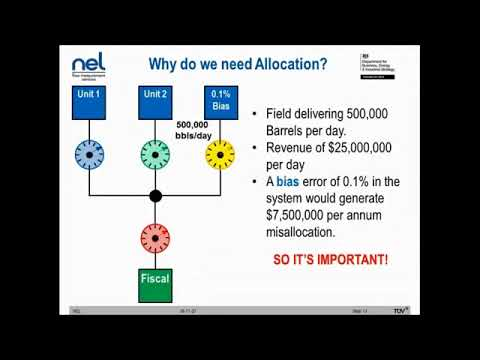

In [31]:
#@title Introduction to Allocation
#@markdown This video gives an intriduction to allocation of oil and gas
from IPython.display import YouTubeVideo
YouTubeVideo('pdIzRGTgmco', width=600, height=400)

# Process simulation for allocation

In [32]:
inputdata = {
  'feedFlowRateWellA': 10,
  'wellPressure': 280.0,
  'wellTemperature':200.0,
  'topsidePressure': 90.0,
  'topsideTemperature': 5.0,
  'firstStagePressure': 75.0,
  'temperatureOilHeater' : 75.9,
  'secondStagePressure': 8.6,
  'thirdStagePressure': 1.9,
  'firstStageSuctionCoolerTemperature': 25.3,
  'secondStageSuctionCoolerTemperature': 24.5,
  'thirdStageSuctionCoolerTemperature':25.0,
  'firstStageExportCoolerTemperature': 25.3,
  'secondStageExportCoolerTemperature': 24.5
}

In [33]:
from neqsim.thermo import fluid, printFrame
from neqsim.process import compressor, cooler, separator3phase, getProcess, clearProcess, mixer, heater, stream, pump, separator, runProcess, stream, saturator, valve, filters, heatExchanger, simpleTEGAbsorber,distillationColumn, waterStripperColumn, recycle2, setpoint, calculator

clearProcess()

wellFluid = fluid('pr')
wellFluid.addComponent("nitrogen", 0.08)
wellFluid.addComponent("CO2", 3.56)
wellFluid.addComponent("methane", 87.36)
wellFluid.addComponent("ethane", 4.02)
wellFluid.addComponent("propane", 1.54)
wellFluid.addComponent("i-butane", 0.2)
wellFluid.addComponent("n-butane", 0.42)
wellFluid.addComponent("i-pentane", 0.15)
wellFluid.addComponent("n-pentane", 0.20)

wellFluid.addTBPfraction("C6", 3.24, 84.99/1000.0, 695.0/1000.0)
wellFluid.addTBPfraction("C7", 1.34, 97.87/1000.0, 718.0/1000.0)
wellFluid.addTBPfraction("C8", 1.33, 111.54/1000.0, 729.0/1000.0)
wellFluid.addTBPfraction("C9", 1.19, 126.1/1000.0, 749.0/1000.0)
wellFluid.addTBPfraction("C10", 1.15, 140.14/1000.0, 760.0/1000.0)
wellFluid.addTBPfraction("C11", 1.69, 175.0/1000.0, 830.0/1000.0)
wellFluid.addTBPfraction("C12", 1.5, 280.0/1000.0, 914.0/1000.0)
wellFluid.addTBPfraction("C13", 2.103, 560.0/1000.0, 980.0/1000.0)

wellFluid.setMixingRule(2)
wellFluid.init(0)

wellFluid.setMolarComposition([0.08, 3.56, 87.36, 4.02, 1.54, 0.2, 0.42, 0.15, 0.2, 1.24, 1.34, 1.33, 1.19, 1.15, 1.69, 1.5, 1.03])

wellStream = stream(wellFluid)
wellStream.setName("dry well stream")
wellStream.setFlowRate(inputdata['feedFlowRateWellA'], "MSm3/day")
wellStream.setTemperature(inputdata['wellTemperature'], "C")
wellStream.setPressure(inputdata['wellPressure'], "bara")

saturatedFeedGas = saturator(wellStream)
saturatedFeedGas.setName("water saturator")

waterSaturatedFeedGas = stream(saturatedFeedGas.getOutStream())
waterSaturatedFeedGas.setName("water saturated feed gas")

feedTPsetter = heater(waterSaturatedFeedGas)
feedTPsetter.setName('inletTP')
feedTPsetter.setOutPressure(inputdata['topsidePressure'], "bara")
feedTPsetter.setOutTemperature(inputdata['topsideTemperature'], "C")

chokeValve = valve(feedTPsetter.getOutStream())
chokeValve.setOutletPressure(inputdata['firstStagePressure'], 'bara')

feedToOffshoreProcess = stream(chokeValve.getOutStream())
feedToOffshoreProcess.setName("feed to offshore")

firstStageSeparator = separator3phase(feedToOffshoreProcess)
firstStageSeparator.setName("1st stage separator")

oilHeaterFromFirstStage = heater(firstStageSeparator.getOilOutStream())
oilHeaterFromFirstStage.setName("oil heater second stage")
oilHeaterFromFirstStage.setOutTemperature(inputdata['temperatureOilHeater'],'C')

oilThrotValve = valve(oilHeaterFromFirstStage.getOutStream())
oilThrotValve.setName("valve oil from first stage")
oilThrotValve.setOutletPressure(inputdata['secondStagePressure'])

secondStageSeparator = separator3phase(oilThrotValve.getOutStream())
secondStageSeparator.setName("2nd stage separator")

oilThrotValve2 = valve(secondStageSeparator.getOilOutStream())
oilThrotValve2.setName("valve oil from second stage")
oilThrotValve2.setOutletPressure(inputdata['thirdStagePressure'])

thirdStageSeparator = separator3phase(oilThrotValve2.getOutStream())
thirdStageSeparator.setName("3rd stage separator")

oilThirdStageToSep =  wellStream.clone()
oilThirdStageToSep.setName("resyc oil")
thirdStageSeparator.addStream(oilThirdStageToSep)

stableOil = stream(thirdStageSeparator.getOilOutStream())
stableOil.setName("stable oil")

stableOilPump = pump(stableOil,15.0,"stable oil pump")

firstStageCooler = cooler(thirdStageSeparator.getGasOutStream())
firstStageCooler.setName("1st stage cooler")
firstStageCooler.setOutTemperature(inputdata['firstStageSuctionCoolerTemperature'],'C')

firstStageScrubber = separator(firstStageCooler.getOutStream())
firstStageScrubber.setName("1st stage scrubber")

firstStageCompressor = compressor(firstStageScrubber.getGasOutStream())
firstStageCompressor.setName("1st stage compressor")
firstStageCompressor.setOutletPressure(inputdata['secondStagePressure'])
firstStageCompressor.setIsentropicEfficiency(0.75)

firststGasMixer = mixer("first Stage mixer")
firststGasMixer.addStream(firstStageCompressor.getOutStream())
firststGasMixer.addStream(secondStageSeparator.getGasOutStream())

secondStageCooler = cooler(firststGasMixer.getOutStream())
secondStageCooler.setName("2nd stage cooler")
secondStageCooler.setOutTemperature(inputdata['secondStageSuctionCoolerTemperature'],'C')

secondStageScrubber = separator(secondStageCooler.getOutStream())
secondStageScrubber.setName("2nd stage scrubber")

secondStageCompressor = compressor(secondStageScrubber.getGasOutStream())
secondStageCompressor.setName("2nd stage compressor")
secondStageCompressor.setOutletPressure(inputdata['firstStagePressure'])
secondStageCompressor.setIsentropicEfficiency(0.75)

richGasMixer = mixer("fourth Stage mixer")
richGasMixer.addStream(secondStageCompressor.getOutStream())
richGasMixer.addStream(firstStageSeparator.getGasOutStream())

dewPointControlCooler = cooler(richGasMixer.getOutStream())
dewPointControlCooler.setName("dew point cooler")
dewPointControlCooler.setOutTemperature(inputdata['thirdStageSuctionCoolerTemperature'],'C')

dewPointScrubber = separator(dewPointControlCooler.getOutStream())
dewPointScrubber.setName("dew point scrubber")

lpLiqmixer = mixer("LP liq gas mixer");
lpLiqmixer.addStream(firstStageScrubber.getLiquidOutStream());
lpLiqmixer.addStream(secondStageScrubber.getLiquidOutStream());
lpLiqmixer.addStream(dewPointScrubber.getLiquidOutStream());

lpResycle = recycle2("LP liq resycle")
lpResycle.addStream(lpLiqmixer.getOutStream())
lpResycle.setOutletStream(oilThirdStageToSep)

exportCompressor1 = compressor(dewPointScrubber.getGasOutStream())
exportCompressor1.setName("export 1st stage")
exportCompressor1.setOutletPressure(140.0)
exportCompressor1.setIsentropicEfficiency(0.75)

exportInterstageCooler = cooler(exportCompressor1.getOutStream())
exportInterstageCooler.setName("interstage stage cooler")
exportInterstageCooler.setOutTemperature(inputdata['firstStageExportCoolerTemperature'],'C')

exportCompressor2= compressor(exportInterstageCooler.getOutStream())
exportCompressor2.setName("export 2nd stage")
exportCompressor2.setOutletPressure(200.0)
exportCompressor2.setIsentropicEfficiency(0.75)

exportCooler = cooler(exportCompressor1.getOutStream())
exportCooler.setName("export cooler")
exportCooler.setOutTemperature(inputdata['secondStageExportCoolerTemperature'],'C')

exportGas = stream(exportCooler.getOutStream())
exportGas.setName("export gas")

oilprocess = getProcess()

In [34]:
oilprocess.run()

In [35]:
TVP = stableOil.TVP(20.0, 'C')
cricondenbar = exportGas.CCB('bara')
gasexport = exportGas.getFlowRate('MSm3/day')
oilexport = stableOil.getFlowRate('m3/hr')

print('TVP [bara] ', TVP)
print('cricondenbar [bara] ', cricondenbar)
print('gas export [MSm3/day] ', gasexport)
print('oil export [m3/hr] ', oilexport)

TVP [bara]  1.0052094606026456
cricondenbar [bara]  92.71002203613847
gas export [MSm3/day]  8.985694498372132
oil export [m3/hr]  400.8707749264762


#ORF factors
In the following code the ORF factors are calculated

In [36]:
componentNames = wellStream.getFluid().getComponentNames()

print ('ORF.......................')
for name in componentNames:
  total = wellStream.getFluid().getComponent(name).getTotalFlowRate('kg/hr')
  ORF = stableOil.getFluid().getComponent(name).getTotalFlowRate('kg/hr')/total
  print('ORF ', name, ' ', ORF)


ORF.......................
ORF  nitrogen   1.752867482152913e-05
ORF  CO2   0.0031583062145849818
ORF  methane   0.00037686751573882434
ORF  ethane   0.015138077368355223
ORF  propane   0.10952978738792997
ORF  i-butane   0.2775181363396506
ORF  n-butane   0.37637050062879074
ORF  i-pentane   0.6187993508613983
ORF  n-pentane   0.6879622585759975
ORF  C6_PC   0.8943638415590003
ORF  C7_PC   0.9607760896105136
ORF  C8_PC   0.9856034413555248
ORF  C9_PC   0.9945850180316577
ORF  C10_PC   0.9976725620268115
ORF  C11_PC   0.9997355649701535
ORF  C12_PC   0.9999996839343801
ORF  C13_PC   0.999999999999769


# Adding a new well stream
In the following example we will add a new well stream and add it to the inlet separator.

In [37]:
inputdata2 = {
  'feedFlowRateWellB': 3,
  'wellPressure': 280.0,
  'wellTemperature':200.0,
  'topsidePressure': 90.0,
  'topsideTemperature': 5.0,
  'firstStagePressure': 75.0,
  'temperatureOilHeater' : 75.9,
  'secondStagePressure': 8.6,
  'thirdStagePressure': 1.9,
  'firstStageSuctionCoolerTemperature': 25.3,
  'secondStageSuctionCoolerTemperature': 24.5,
  'thirdStageSuctionCoolerTemperature':25.0,
  'firstStageExportCoolerTemperature': 25.3,
  'secondStageExportCoolerTemperature': 24.5
}

In [38]:
wellFluid2 = fluid('pr')
wellFluid2.addComponent("nitrogen", 0.08)
wellFluid2.addComponent("CO2", 3.56)
wellFluid2.addComponent("methane", 87.36)
wellFluid2.addComponent("ethane", 4.02)
wellFluid2.addComponent("propane", 1.54)
wellFluid2.addComponent("i-butane", 0.2)
wellFluid2.addComponent("n-butane", 0.42)
wellFluid2.addComponent("i-pentane", 0.15)
wellFluid2.addComponent("n-pentane", 0.20)

wellFluid2.addTBPfraction("C6", 3.24, 84.99/1000.0, 695.0/1000.0)
wellFluid2.addTBPfraction("C7", 1.34, 97.87/1000.0, 718.0/1000.0)
wellFluid2.addTBPfraction("C8", 1.33, 111.54/1000.0, 729.0/1000.0)
wellFluid2.addTBPfraction("C9", 1.19, 126.1/1000.0, 749.0/1000.0)
wellFluid2.addTBPfraction("C10", 1.15, 140.14/1000.0, 760.0/1000.0)
wellFluid2.addTBPfraction("C11", 1.69, 175.0/1000.0, 830.0/1000.0)
wellFluid2.addTBPfraction("C12", 1.5, 280.0/1000.0, 914.0/1000.0)
wellFluid2.addTBPfraction("C13", 2.103, 560.0/1000.0, 980.0/1000.0)

wellFluid2.setMixingRule(2)
wellFluid2.init(0)

wellFluid2.setMolarComposition([0.08, 3.56, 45.36, 4.02, 1.54, 0.2, 0.42, 0.15, 0.2, 1.24, 1.34, 1.33, 1.19, 2.15, 2.69, 3.5, 1.03])

wellStream2 = stream(wellFluid2)
wellStream2.setName("dry well stream 2")
wellStream2.setFlowRate(inputdata2['feedFlowRateWellB'], "MSm3/day")
wellStream2.setTemperature(inputdata2['wellTemperature'], "C")
wellStream2.setPressure(inputdata2['wellPressure'], "bara")


saturatedFeedGas2 = saturator(wellStream2)
saturatedFeedGas2.setName("water saturator 2")

waterSaturatedFeedGas2 = stream(saturatedFeedGas2.getOutStream())
waterSaturatedFeedGas2.setName("water saturated feed gas 2")

feedTPsetter2 = heater(waterSaturatedFeedGas2)
feedTPsetter2.setName('inletTP')
feedTPsetter2.setOutPressure(inputdata['topsidePressure'], "bara")
feedTPsetter2.setOutTemperature(inputdata['topsideTemperature'], "C")

firstStageSeparator.addStream(feedTPsetter2.getOutStream())

In [39]:
# wellStream.setFlowRate(1.0e-6, 'kg/hr')  #uncomment it you new well to be run alone
oilprocess.run()

In [40]:
TVP = stableOil.TVP(20.0, 'C')
cricondenbar = exportGas.CCB('bara')
gasexport = exportGas.getFlowRate('MSm3/day')
oilexport = stableOil.getFlowRate('m3/hr')

print('TVP [bara] ', TVP)
print('cricondenbar [bara] ', cricondenbar)
print('gas export [MSm3/day] ', gasexport)
print('oil export [m3/hr] ', oilexport)

TVP [bara]  1.0116125586732616
cricondenbar [bara]  92.94931395113228
gas export [MSm3/day]  11.335272316386336
oil export [m3/hr]  666.2813873174427


In [41]:
componentNames = wellStream.getFluid().getComponentNames()

print ('ORF.......................')
for name in componentNames:
  total = wellStream.getFluid().getComponent(name).getTotalFlowRate('kg/hr')+wellStream2.getFluid().getComponent(name).getTotalFlowRate('kg/hr')
  ORF = stableOil.getFluid().getComponent(name).getTotalFlowRate('kg/hr')/total
  print('ORF ', name, ' ', ORF)

ORF.......................
ORF  nitrogen   2.3520339595319078e-05
ORF  CO2   0.0039669852688277085
ORF  methane   0.0004926258215878587
ORF  ethane   0.018386752345276487
ORF  propane   0.1231498608910212
ORF  i-butane   0.297957503219527
ORF  n-butane   0.39603888555659433
ORF  i-pentane   0.6335226251488559
ORF  n-pentane   0.6996366037314387
ORF  C6_PC   0.8988915086772578
ORF  C7_PC   0.9637951439532014
ORF  C8_PC   0.9876347830891222
ORF  C9_PC   0.9956624343592636
ORF  C10_PC   0.9982029007179809
ORF  C11_PC   0.9997996519860115
ORF  C12_PC   0.9999997558570332
ORF  C13_PC   0.9999999999998592


# Comment
As we can see the ORF of the light components like eg. propane are now a bit higher. This is due to more of the lighter components are extracted in the oil of the more oil dominated new well.

## Tracking induvidual components from wells

In [42]:
wellFluid = fluid('pr')
wellFluid.addComponent("nitrogen", 0.08)
wellFluid.addComponent("CO2", 3.56)
wellFluid.addComponent("methane", 87.36)
wellFluid.addComponent("ethane", 4.02)
wellFluid.addComponent("propane", 1.54)
wellFluid.addComponent("i-butane", 0.2)
wellFluid.addComponent("n-butane", 0.42)
wellFluid.addComponent("i-pentane", 0.15)
wellFluid.addComponent("n-pentane", 0.20)

wellFluid.addTBPfraction("C6", 3.24, 84.99/1000.0, 695.0/1000.0)
wellFluid.addTBPfraction("C7", 1.34, 97.87/1000.0, 718.0/1000.0)
wellFluid.addTBPfraction("C8", 1.33, 111.54/1000.0, 729.0/1000.0)
wellFluid.addTBPfraction("C9", 1.19, 126.1/1000.0, 749.0/1000.0)
wellFluid.addTBPfraction("C10", 1.15, 140.14/1000.0, 760.0/1000.0)
wellFluid.addTBPfraction("C11", 1.69, 175.0/1000.0, 830.0/1000.0)
wellFluid.addTBPfraction("C12", 1.5, 280.0/1000.0, 914.0/1000.0)
wellFluid.addTBPfraction("C13", 2.103, 560.0/1000.0, 980.0/1000.0)

names = wellFluid.getComponentNames()

for i in range(names.length):
  wellFluid.changeComponentName(wellFluid.getComponent(i).getName(), (wellFluid.getComponent(i).getName()+"_well1"))

wellFluid.addComponent("nitrogen", 0.08)
wellFluid.addComponent("CO2", 3.56)
wellFluid.addComponent("methane", 87.36)
wellFluid.addComponent("ethane", 4.02)
wellFluid.addComponent("propane", 1.54)
wellFluid.addComponent("i-butane", 0.2)
wellFluid.addComponent("n-butane", 0.42)
wellFluid.addComponent("i-pentane", 0.15)
wellFluid.addComponent("n-pentane", 0.20)

wellFluid.addTBPfraction("C6", 3.24, 82.99/1000.0, 695.0/1000.0)
wellFluid.addTBPfraction("C7", 1.34, 95.87/1000.0, 718.0/1000.0)
wellFluid.addTBPfraction("C8", 1.33, 121.54/1000.0, 729.0/1000.0)
wellFluid.addTBPfraction("C9", 1.19, 136.1/1000.0, 749.0/1000.0)
wellFluid.addTBPfraction("C10", 1.15, 150.14/1000.0, 760.0/1000.0)
wellFluid.addTBPfraction("C11", 1.69, 175.0/1000.0, 830.0/1000.0)
wellFluid.addTBPfraction("C12", 1.5, 310.0/1000.0, 914.0/1000.0)
wellFluid.addTBPfraction("C13", 2.103, 520.0/1000.0, 980.0/1000.0)

for i in range(names.length):
  wellFluid.changeComponentName(names[i], (wellFluid.getComponent(i).getName().replace("well1", "well2")))

wellFluid.setMixingRule('classic')

printFrame(wellFluid)


#and then set the fluid composition of the wells and run simulation

from neqsim.thermo import fluid, printFrame
from neqsim.process import compressor, cooler, separator3phase, getProcess, clearProcess, mixer, heater, stream, pump, separator, runProcess, stream, saturator, valve, filters, heatExchanger, simpleTEGAbsorber,distillationColumn, waterStripperColumn, recycle2, setpoint, calculator

wellFluid.setMolarComposition([0.08, 3.56, 87.36, 4.02, 1.54, 0.2, 0.42, 0.15, 0.2, 1.24, 1.34, 1.33, 1.19, 1.15, 1.69, 1.5, 1.03,
                               0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])


welFluid2 = wellFluid.clone()
welFluid2.setMolarComposition([ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                               1.08, 3.56, 45.36, 2.02, 7.54, 5.2, 0.42, 0.15, 0.2, 1.24, 1.34, 1.33, 1.19, 1.15, 1.69, 1.5, 1.03])

clearProcess()

wellStream = stream(wellFluid)
wellStream.setName("dry well stream")
wellStream.setFlowRate(inputdata['feedFlowRateWellA'], "MSm3/day")
wellStream.setTemperature(inputdata['wellTemperature'], "C")
wellStream.setPressure(inputdata['wellPressure'], "bara")

wellStream2 = stream(welFluid2)
wellStream2.setName("dry well stream2")
wellStream2.setFlowRate(inputdata['feedFlowRateWellA'], "MSm3/day")
wellStream2.setTemperature(inputdata['wellTemperature'], "C")
wellStream2.setPressure(inputdata['wellPressure'], "bara")

wellmixer = mixer('mixer')
wellmixer.addStream(wellStream)
wellmixer.addStream(wellStream2)

feedTPsetter = heater(wellmixer.getOutletStream())
feedTPsetter.setName('inletTP')
feedTPsetter.setOutPressure(inputdata['topsidePressure'], "bara")
feedTPsetter.setOutTemperature(inputdata['topsideTemperature'], "C")

chokeValve = valve(feedTPsetter.getOutStream())
chokeValve.setOutletPressure(inputdata['firstStagePressure'], 'bara')

feedToOffshoreProcess = stream(chokeValve.getOutStream())
feedToOffshoreProcess.setName("feed to offshore")

firstStageSeparator = separator3phase(feedToOffshoreProcess)
firstStageSeparator.setName("1st stage separator")

oilHeaterFromFirstStage = heater(firstStageSeparator.getOilOutStream())
oilHeaterFromFirstStage.setName("oil heater second stage")
oilHeaterFromFirstStage.setOutTemperature(inputdata['temperatureOilHeater'],'C')

oilThrotValve = valve(oilHeaterFromFirstStage.getOutStream())
oilThrotValve.setName("valve oil from first stage")
oilThrotValve.setOutletPressure(inputdata['secondStagePressure'])

secondStageSeparator = separator3phase(oilThrotValve.getOutStream())
secondStageSeparator.setName("2nd stage separator")

oilThrotValve2 = valve(secondStageSeparator.getOilOutStream())
oilThrotValve2.setName("valve oil from second stage")
oilThrotValve2.setOutletPressure(inputdata['thirdStagePressure'])

thirdStageSeparator = separator3phase(oilThrotValve2.getOutStream())
thirdStageSeparator.setName("3rd stage separator")

oilThirdStageToSep =  wellStream.clone()
oilThirdStageToSep.setName("resyc oil")
thirdStageSeparator.addStream(oilThirdStageToSep)

stableOil = stream(thirdStageSeparator.getOilOutStream())
stableOil.setName("stable oil")

stableOilPump = pump(stableOil,15.0,"stable oil pump")

firstStageCooler = cooler(thirdStageSeparator.getGasOutStream())
firstStageCooler.setName("1st stage cooler")
firstStageCooler.setOutTemperature(inputdata['firstStageSuctionCoolerTemperature'],'C')

firstStageScrubber = separator(firstStageCooler.getOutStream())
firstStageScrubber.setName("1st stage scrubber")

firstStageCompressor = compressor(firstStageScrubber.getGasOutStream())
firstStageCompressor.setName("1st stage compressor")
firstStageCompressor.setOutletPressure(inputdata['secondStagePressure'])
firstStageCompressor.setIsentropicEfficiency(0.75)

firststGasMixer = mixer("first Stage mixer")
firststGasMixer.addStream(firstStageCompressor.getOutStream())
firststGasMixer.addStream(secondStageSeparator.getGasOutStream())

secondStageCooler = cooler(firststGasMixer.getOutStream())
secondStageCooler.setName("2nd stage cooler")
secondStageCooler.setOutTemperature(inputdata['secondStageSuctionCoolerTemperature'],'C')

secondStageScrubber = separator(secondStageCooler.getOutStream())
secondStageScrubber.setName("2nd stage scrubber")

secondStageCompressor = compressor(secondStageScrubber.getGasOutStream())
secondStageCompressor.setName("2nd stage compressor")
secondStageCompressor.setOutletPressure(inputdata['firstStagePressure'])
secondStageCompressor.setIsentropicEfficiency(0.75)

richGasMixer = mixer("fourth Stage mixer")
richGasMixer.addStream(secondStageCompressor.getOutStream())
richGasMixer.addStream(firstStageSeparator.getGasOutStream())

dewPointControlCooler = cooler(richGasMixer.getOutStream())
dewPointControlCooler.setName("dew point cooler")
dewPointControlCooler.setOutTemperature(inputdata['thirdStageSuctionCoolerTemperature'],'C')

dewPointScrubber = separator(dewPointControlCooler.getOutStream())
dewPointScrubber.setName("dew point scrubber")

lpLiqmixer = mixer("LP liq gas mixer");
lpLiqmixer.addStream(firstStageScrubber.getLiquidOutStream());
lpLiqmixer.addStream(secondStageScrubber.getLiquidOutStream());
lpLiqmixer.addStream(dewPointScrubber.getLiquidOutStream());

lpResycle = recycle2("LP liq resycle")
lpResycle.addStream(lpLiqmixer.getOutStream())
lpResycle.setOutletStream(oilThirdStageToSep)

exportCompressor1 = compressor(dewPointScrubber.getGasOutStream())
exportCompressor1.setName("export 1st stage")
exportCompressor1.setOutletPressure(140.0)
exportCompressor1.setIsentropicEfficiency(0.75)

exportInterstageCooler = cooler(exportCompressor1.getOutStream())
exportInterstageCooler.setName("interstage stage cooler")
exportInterstageCooler.setOutTemperature(inputdata['firstStageExportCoolerTemperature'],'C')

exportCompressor2= compressor(exportInterstageCooler.getOutStream())
exportCompressor2.setName("export 2nd stage")
exportCompressor2.setOutletPressure(200.0)
exportCompressor2.setIsentropicEfficiency(0.75)

exportCooler = cooler(exportCompressor1.getOutStream())
exportCooler.setName("export cooler")
exportCooler.setOutTemperature(inputdata['secondStageExportCoolerTemperature'],'C')

exportGas = stream(exportCooler.getOutStream())
exportGas.setName("export gas")

oilprocess = getProcess()

| 0                  | 1          | 2          | 3          | 4   | 5   | 6               |
|:-------------------|:-----------|:-----------|:-----------|:----|:----|:----------------|
|                    | total      | GAS        | OIL        |     |     |                 |
| nitrogen_well1     | 3.60124E-4 | 3.60124E-4 | 3.60124E-4 |     |     | [mole fraction] |
| CO2_well1          | 1.60255E-2 | 1.60255E-2 | 1.60255E-2 |     |     | [mole fraction] |
| methane_well1      | 3.93255E-1 | 3.93255E-1 | 3.93255E-1 |     |     | [mole fraction] |
| ethane_well1       | 1.80962E-2 | 1.80962E-2 | 1.80962E-2 |     |     | [mole fraction] |
| propane_well1      | 6.93238E-3 | 6.93238E-3 | 6.93238E-3 |     |     | [mole fraction] |
| i-butane_well1     | 9.00309E-4 | 9.00309E-4 | 9.00309E-4 |     |     | [mole fraction] |
| n-butane_well1     | 1.89065E-3 | 1.89065E-3 | 1.89065E-3 |     |     | [mole fraction] |
| i-pentane_well1    | 6.75232E-4 | 6.75232E-4 | 6.75232E-4 |     |     | [mole 

In [43]:
oilprocess.run()

In [44]:
TVP = stableOil.TVP(20.0, 'C')
cricondenbar = exportGas.CCB('bara')
gasexport = exportGas.getFlowRate('MSm3/day')
oilexport = stableOil.getFlowRate('m3/hr')

print('TVP [bara] ', TVP)
print('cricondenbar [bara] ', cricondenbar)
print('gas export [MSm3/day] ', gasexport)
print('oil export [m3/hr] ', oilexport)

TVP [bara]  0.9879870053584401
cricondenbar [bara]  102.72635953281646
gas export [MSm3/day]  17.32793532166701
oil export [m3/hr]  1011.5725095505974


In [45]:
printFrame(exportGas.getFluid())

| 0                  | 1           | 2           | 3   | 4   | 5   | 6               |
|:-------------------|:------------|:------------|:----|:----|:----|:----------------|
|                    | total       | GAS         |     |     |     |                 |
| nitrogen_well1     | 4.27475E-4  | 4.27475E-4  |     |     |     | [mole fraction] |
| CO2_well1          | 1.88941E-2  | 1.88941E-2  |     |     |     | [mole fraction] |
| methane_well1      | 4.66685E-1  | 4.66685E-1  |     |     |     | [mole fraction] |
| ethane_well1       | 2.12307E-2  | 2.12307E-2  |     |     |     | [mole fraction] |
| propane_well1      | 7.48218E-3  | 7.48218E-3  |     |     |     | [mole fraction] |
| i-butane_well1     | 8.05698E-4  | 8.05698E-4  |     |     |     | [mole fraction] |
| n-butane_well1     | 1.4805E-3   | 1.4805E-3   |     |     |     | [mole fraction] |
| i-pentane_well1    | 3.2863E-4   | 3.2863E-4   |     |     |     | [mole fraction] |
| n-pentane_well1    | 3.60469E-4  | 3.6046

calculation of ORF factors for the induvidual components from well 1 and 2.

In [46]:
componentNames = wellStream.getFluid().getComponentNames()

print ('ORF factors.......................')
for name in componentNames:
  total = wellStream.getFluid().getComponent(name).getTotalFlowRate('kg/hr') + wellStream2.getFluid().getComponent(name).getTotalFlowRate('kg/hr')
  ORF = stableOil.getFluid().getComponent(name).getTotalFlowRate('kg/hr')/total
  print('ORF ', name, ' ', ORF)

ORF factors.......................
ORF  nitrogen_well1   1.9660369911838256e-05
ORF  CO2_well1   0.00677730461279986
ORF  methane_well1   0.0002716786138988942
ORF  ethane_well1   0.011653468930230799
ORF  propane_well1   0.09075826027783129
ORF  i-butane_well1   0.24609225812357086
ORF  n-butane_well1   0.34031176817853737
ORF  i-pentane_well1   0.5899772774334563
ORF  n-pentane_well1   0.6626843607326044
ORF  C6_PC_well1   0.889633024903191
ORF  C7_PC_well1   0.9632522492439479
ORF  C8_PC_well1   0.9887598638389035
ORF  C9_PC_well1   0.9963878892301804
ORF  C10_PC_well1   0.9985475234629053
ORF  C11_PC_well1   0.9998320573594831
ORF  C12_PC_well1   0.9999997486768035
ORF  C13_PC_well1   0.9999999999999661
ORF  nitrogen_well2   1.9660369908117234e-05
ORF  CO2_well2   0.006777304453327738
ORF  methane_well2   0.0002716786134996127
ORF  ethane_well2   0.011653468421779343
ORF  propane_well2   0.09075822757801508
ORF  i-butane_well2   0.24609197720709095
ORF  n-butane_well2   0.340311214

In [47]:
#calculation of flow of wellstream 1 in oil and gas export

componentNames = wellStream.getFluid().getComponentNames()

totalGasFlowFromWell1 = 0
totalOilFlowFromWell1 = 0
for name in componentNames:
  if(wellStream.getFluid().getComponent(name).getz()>0):
    totalGasFlowFromWell1 = totalGasFlowFromWell1 + exportGas.getFluid().getComponent(name).getFlowRate('kg/hr')
    totalOilFlowFromWell1 = totalOilFlowFromWell1 + stableOil.getFluid().getComponent(name).getFlowRate('kg/hr')

print('well stream 1 flow ' , wellStream.getFlowRate('kg/hr'), ' kg/hr')
print('well stream 1 in export gas ', totalGasFlowFromWell1, ' kg/hr')
print('well stream 1 in stable oil ', totalOilFlowFromWell1, ' kg/hr')


well stream 1 flow  619893.2766954034  kg/hr
well stream 1 in export gas  292608.6161569333  kg/hr
well stream 1 in stable oil  327283.9767350981  kg/hr


Evaluating effect of production rate of well 1 for well 2 gas/oil export allocation

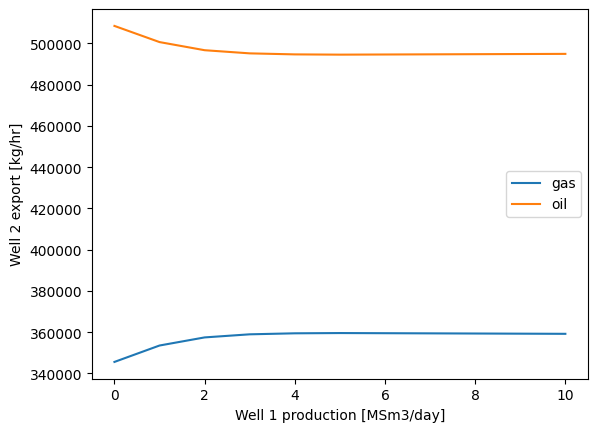

In [49]:
import matplotlib.pyplot as plt

well1production = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
well2Gas = []
well2Oil = []

#set flow from well 2
oilprocess.getUnit('dry well stream2').setFlowRate(10.0, "MSm3/day")

for production in well1production:
  oilprocess.getUnit('dry well stream').setFlowRate(production, "MSm3/day")
  oilprocess.run()

  totalGasFlowFromWell2 = 0
  totalOilFlowFromWell2 = 0
  for name in componentNames:
    if(wellStream2.getFluid().getComponent(name).getz()>0):
      totalGasFlowFromWell2 = totalGasFlowFromWell2 + exportGas.getFluid().getComponent(name).getFlowRate('kg/hr')
      totalOilFlowFromWell2 = totalOilFlowFromWell2 + stableOil.getFluid().getComponent(name).getFlowRate('kg/hr')
  well2Gas.append(totalGasFlowFromWell2)
  well2Oil.append(totalOilFlowFromWell2)

plt.figure()
plt.xlabel('Well 1 production [MSm3/day]')
plt.ylabel('Well 2 export [kg/hr]')
plt.plot(well1production, well2Gas)
plt.plot(well1production, well2Oil)
plt.legend(['gas', 'oil'])